<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB
None 


                Open           High            Low          Close  \
count  104224.000000  104224.000000  104224.000000  104224.000000   
mean     8015.353334    8063.324234    7962.581120    8014.366642   
std      9140.563404    9196.575802    9082.767802    9140.609758   
min        54.869999      54.869999      54.869999      54.869999   
25%      2046.887756    2057.21399

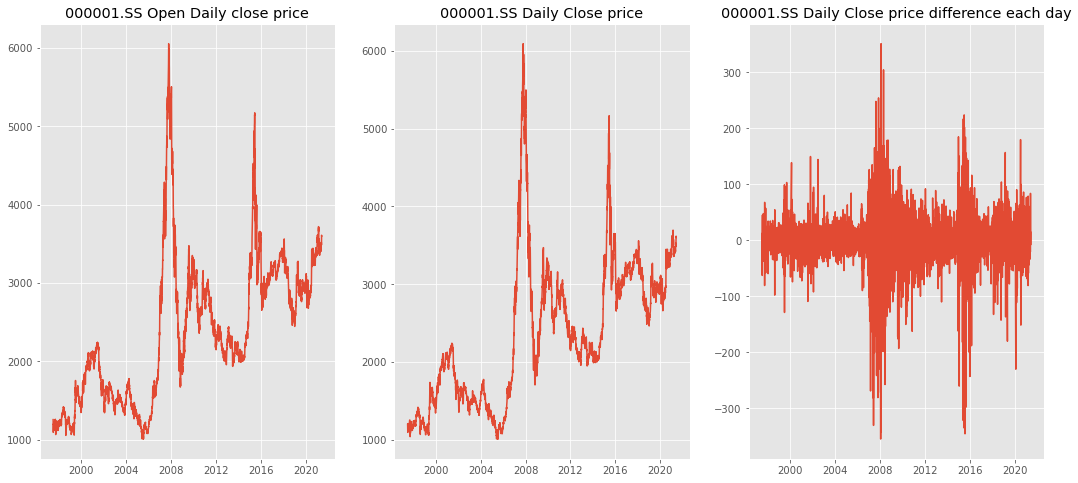

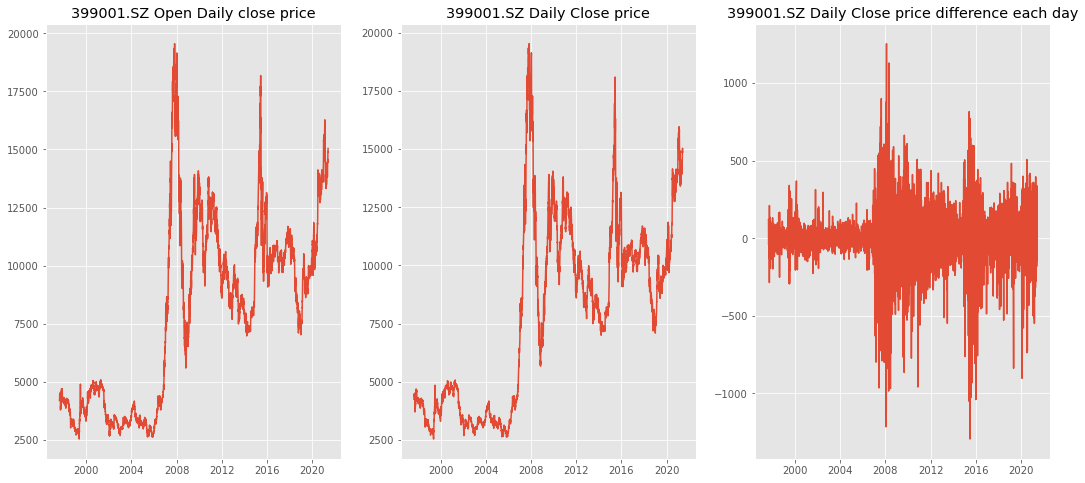

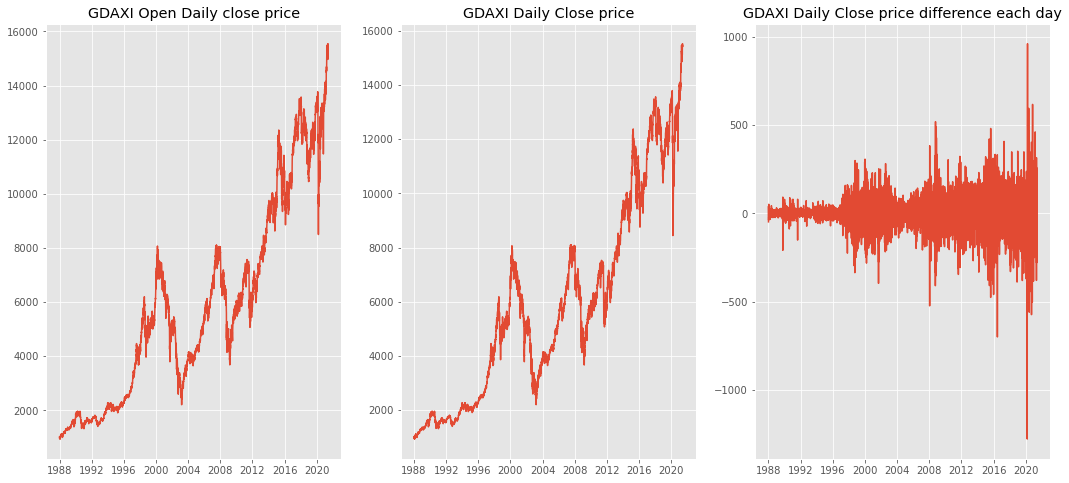

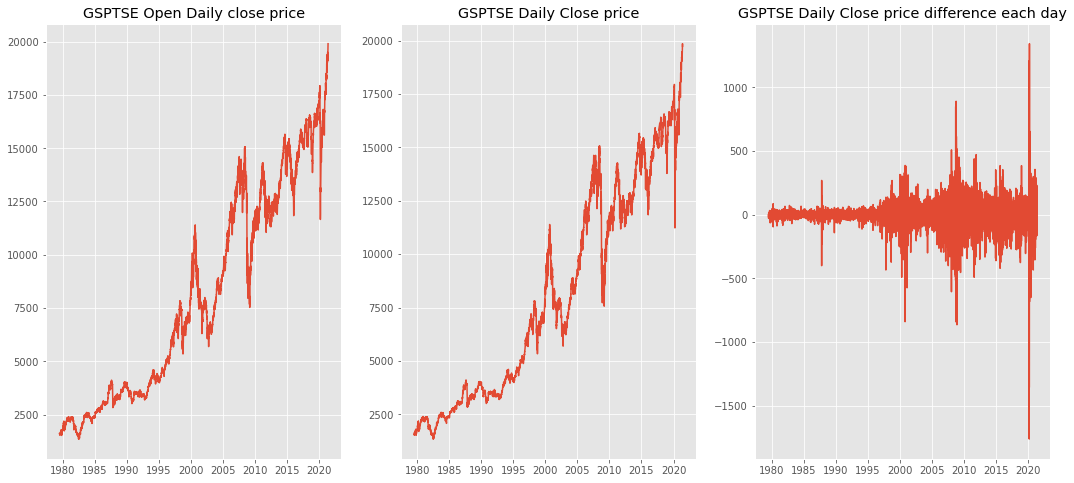

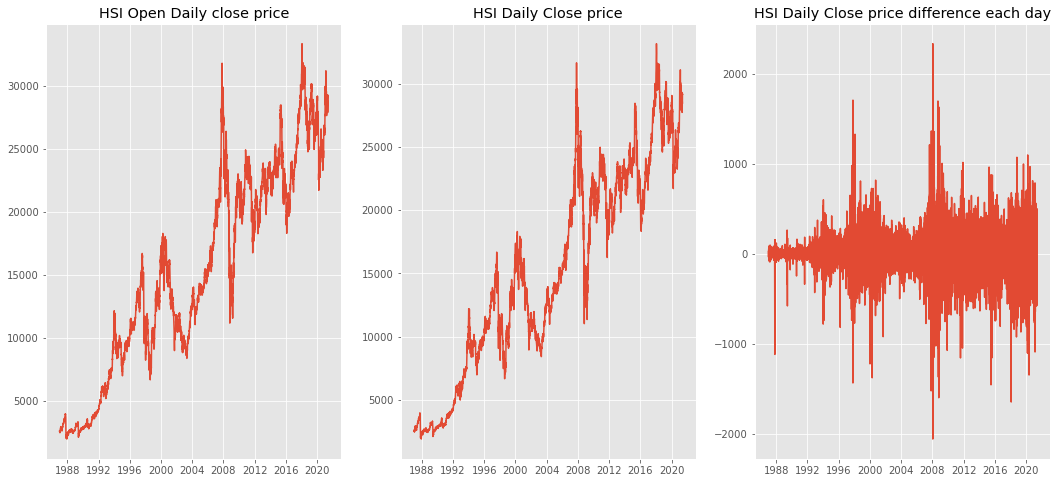

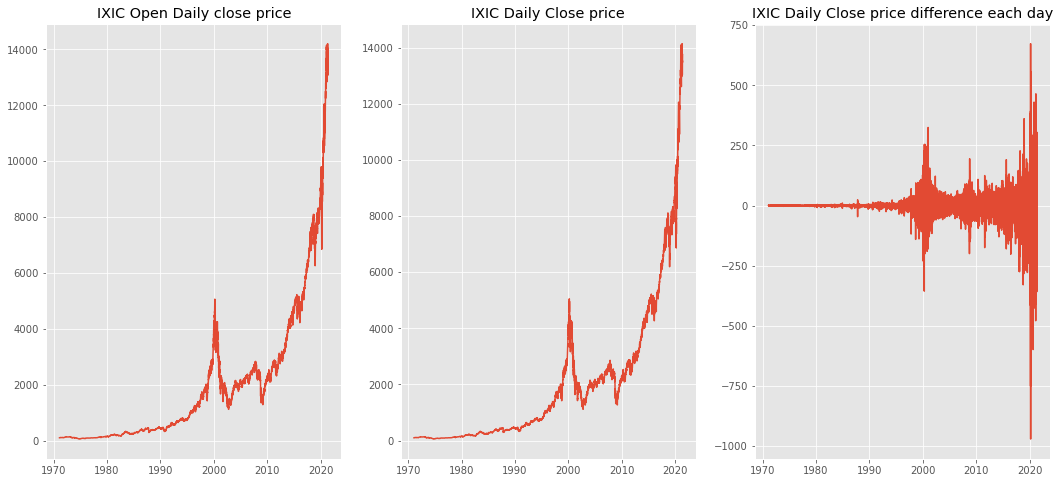

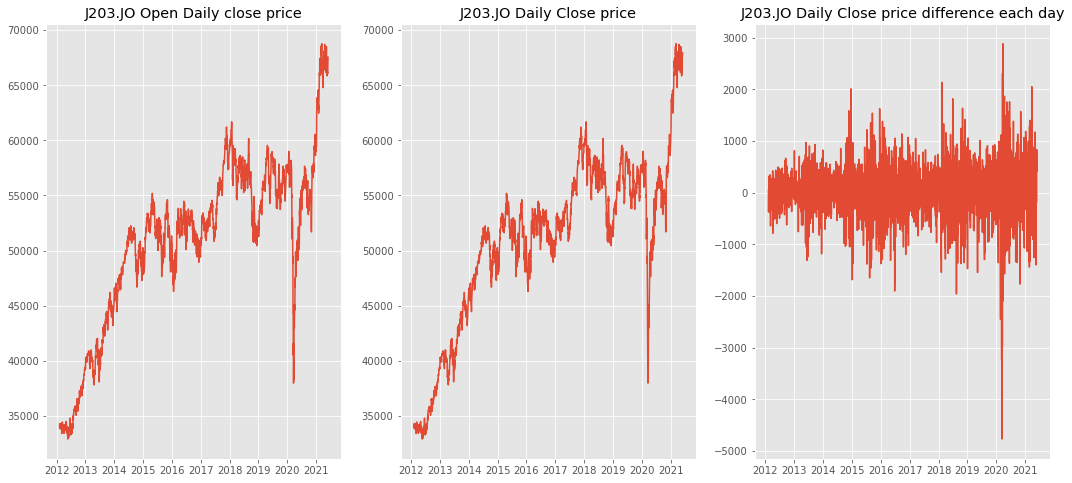

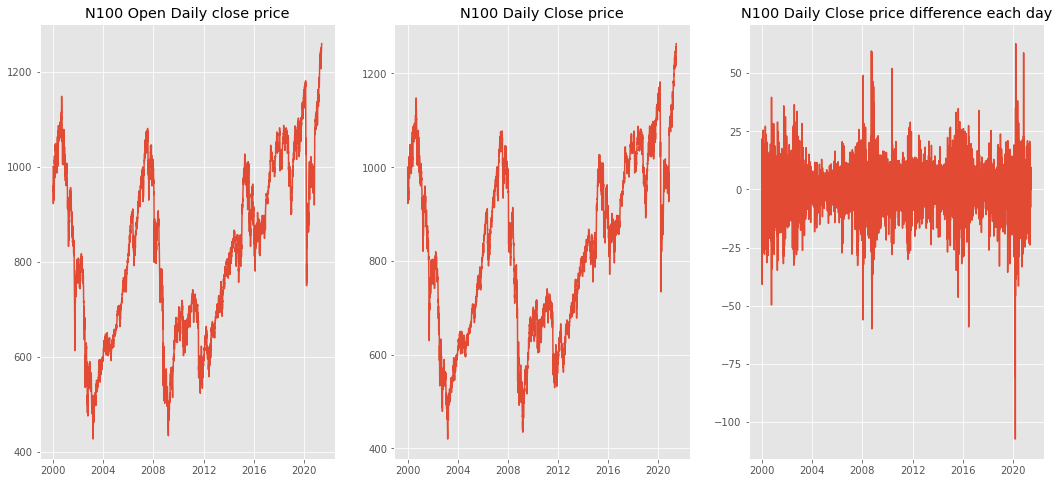

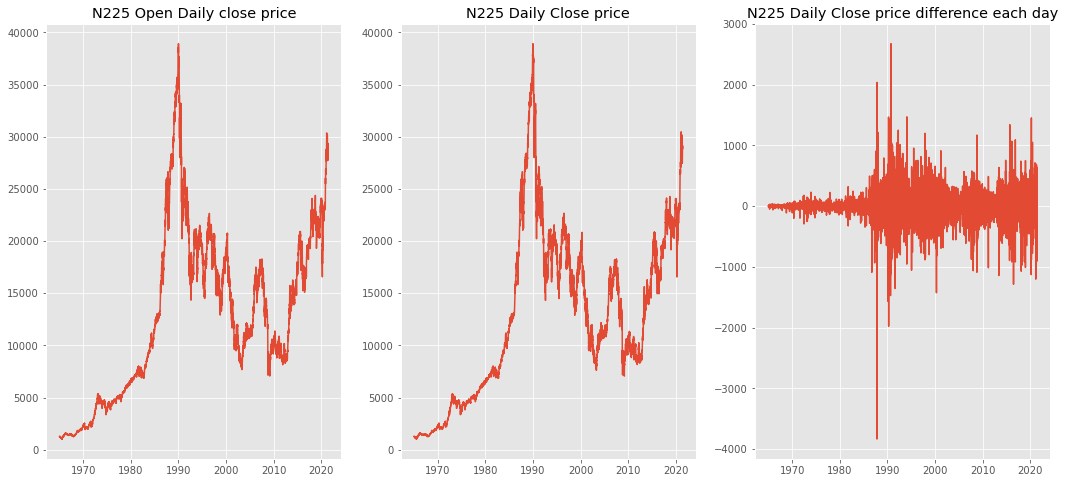

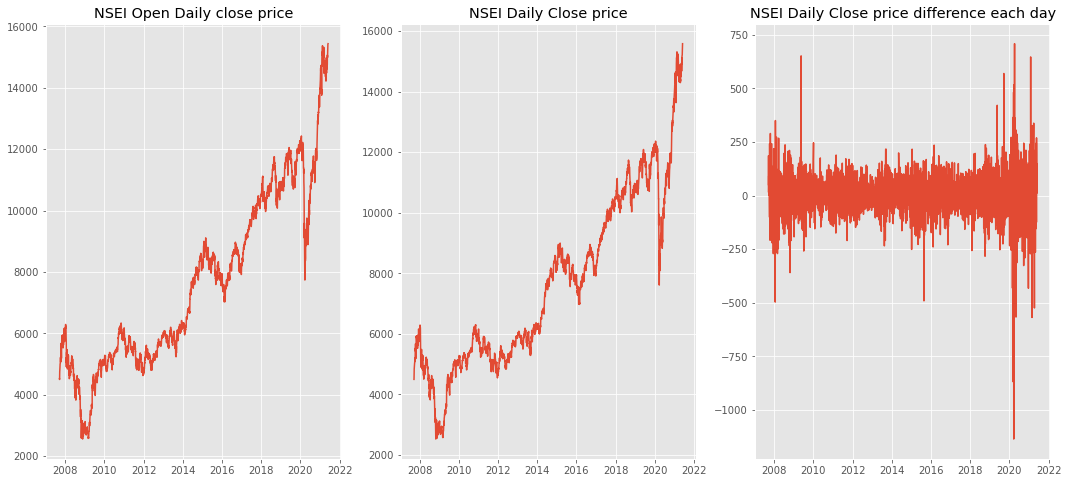

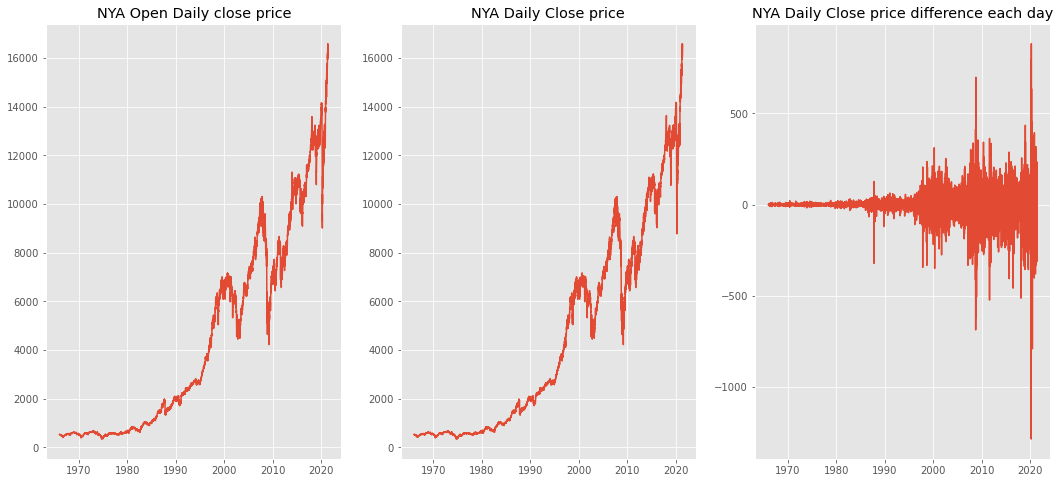

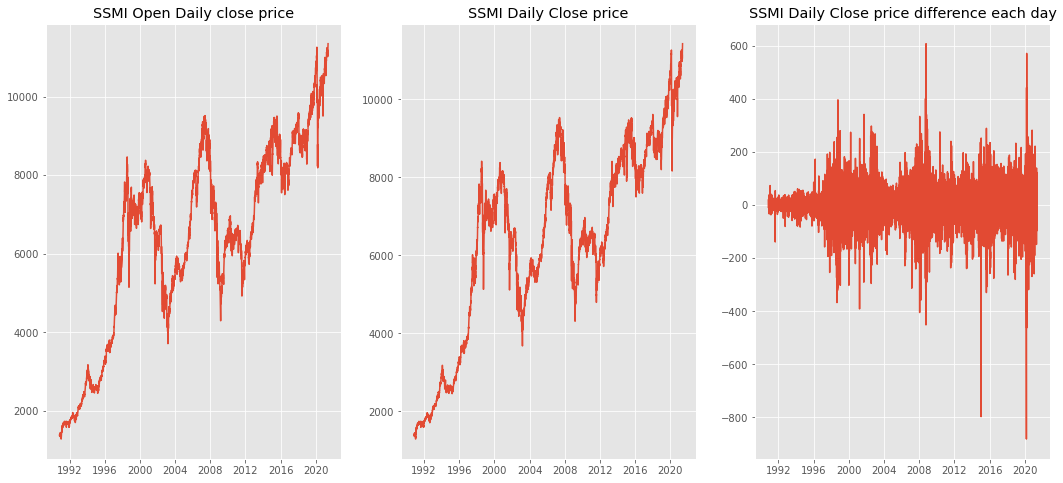

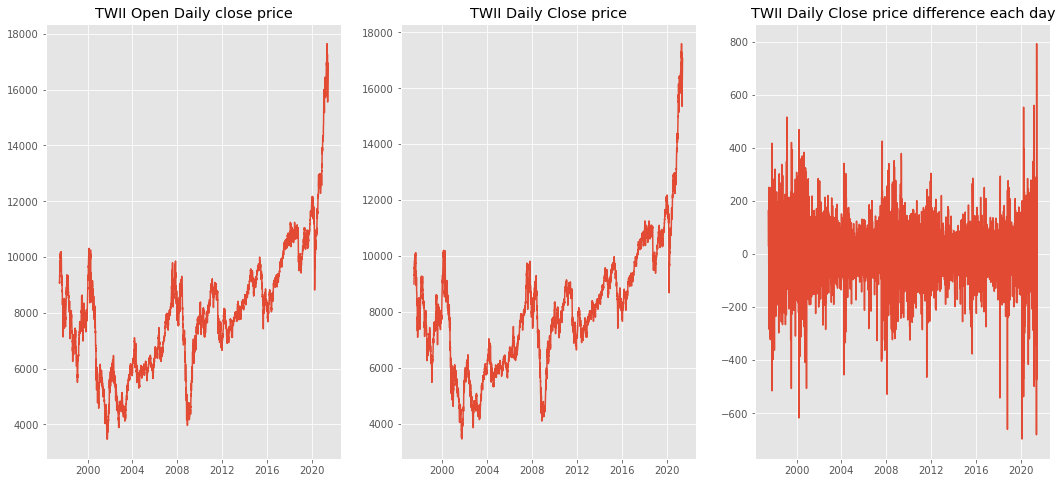

C:\Users\User\AppData\Local\Temp\ipykernel_7420\4142953881.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdaxi_df["Open_Close"] = gdaxi_df["Close"].values - gdaxi_df["Open"].values


Index         0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
CloseUSD      0
Open_Close    0
dtype: int64


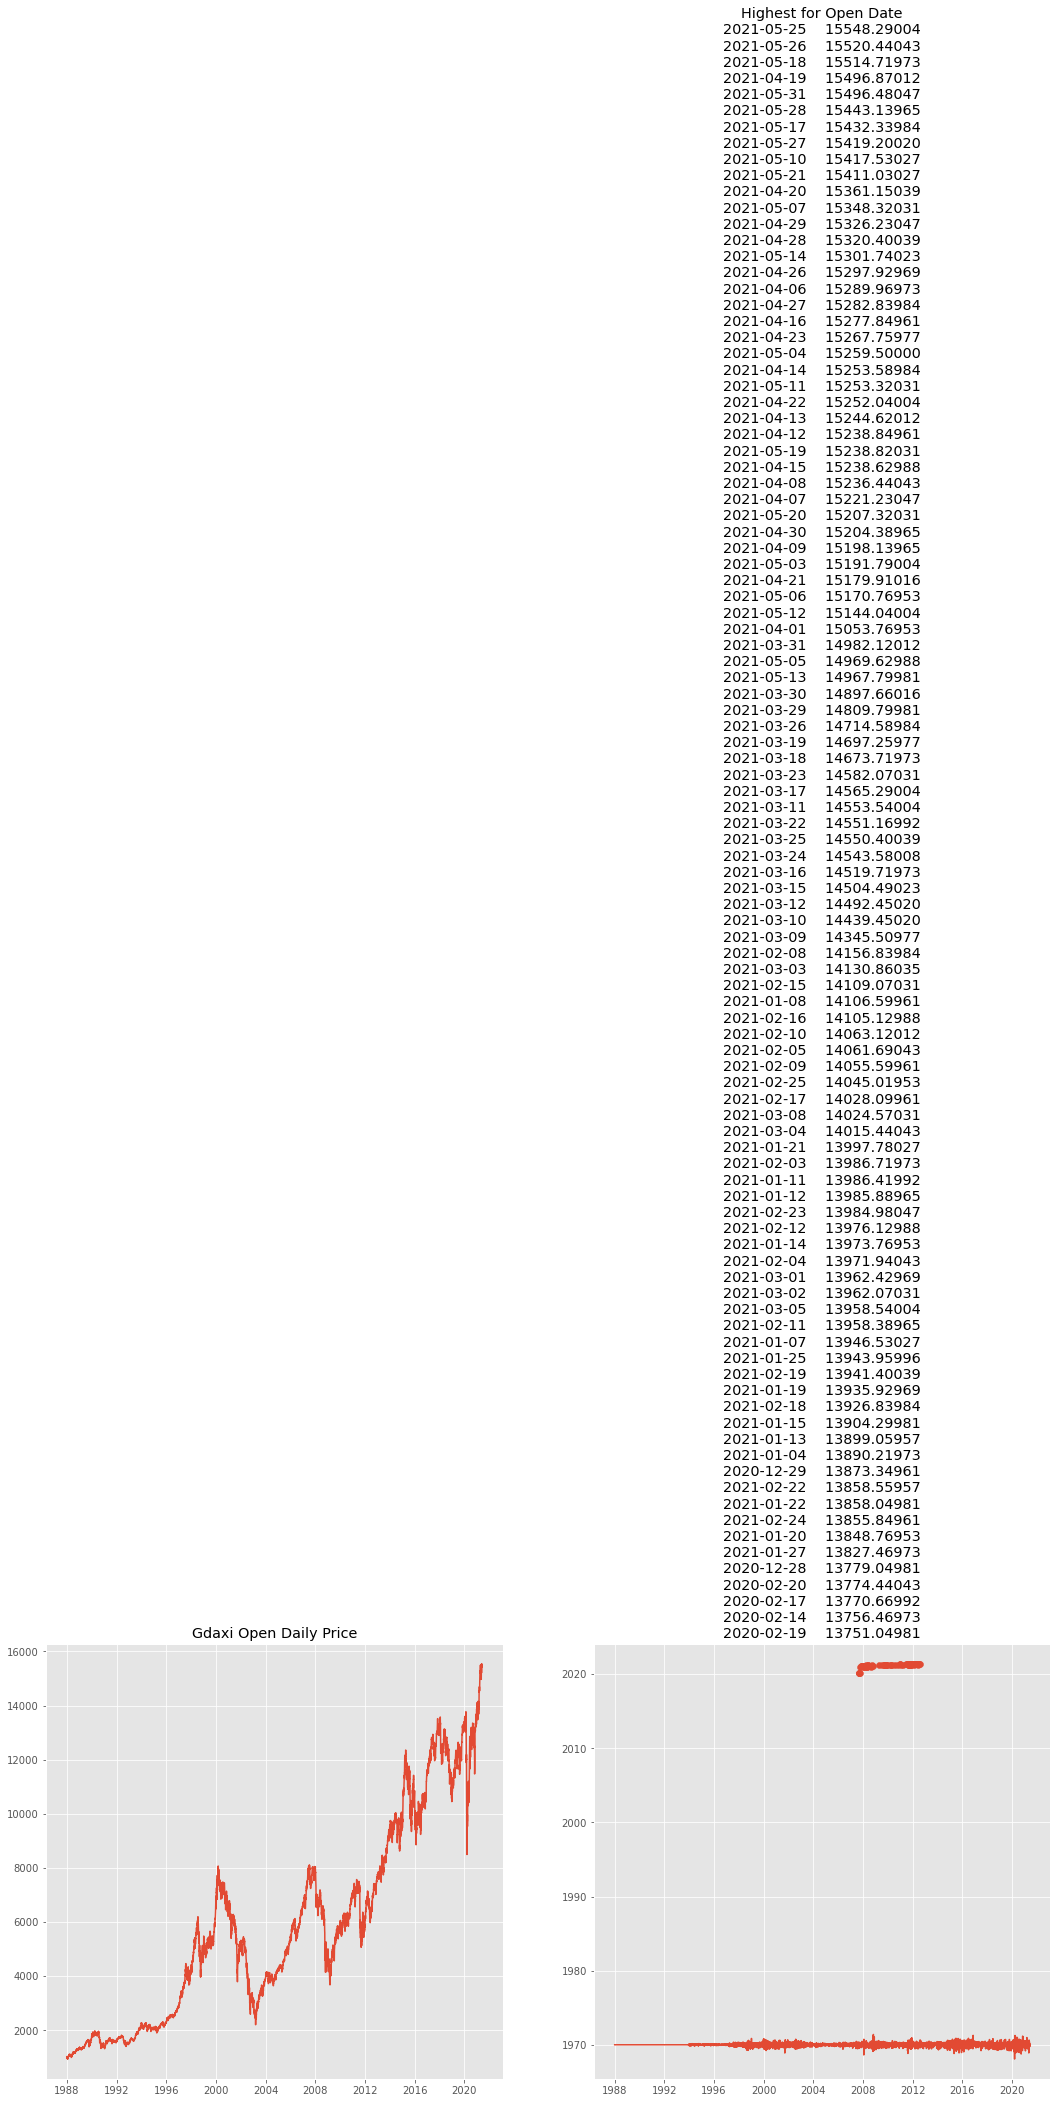

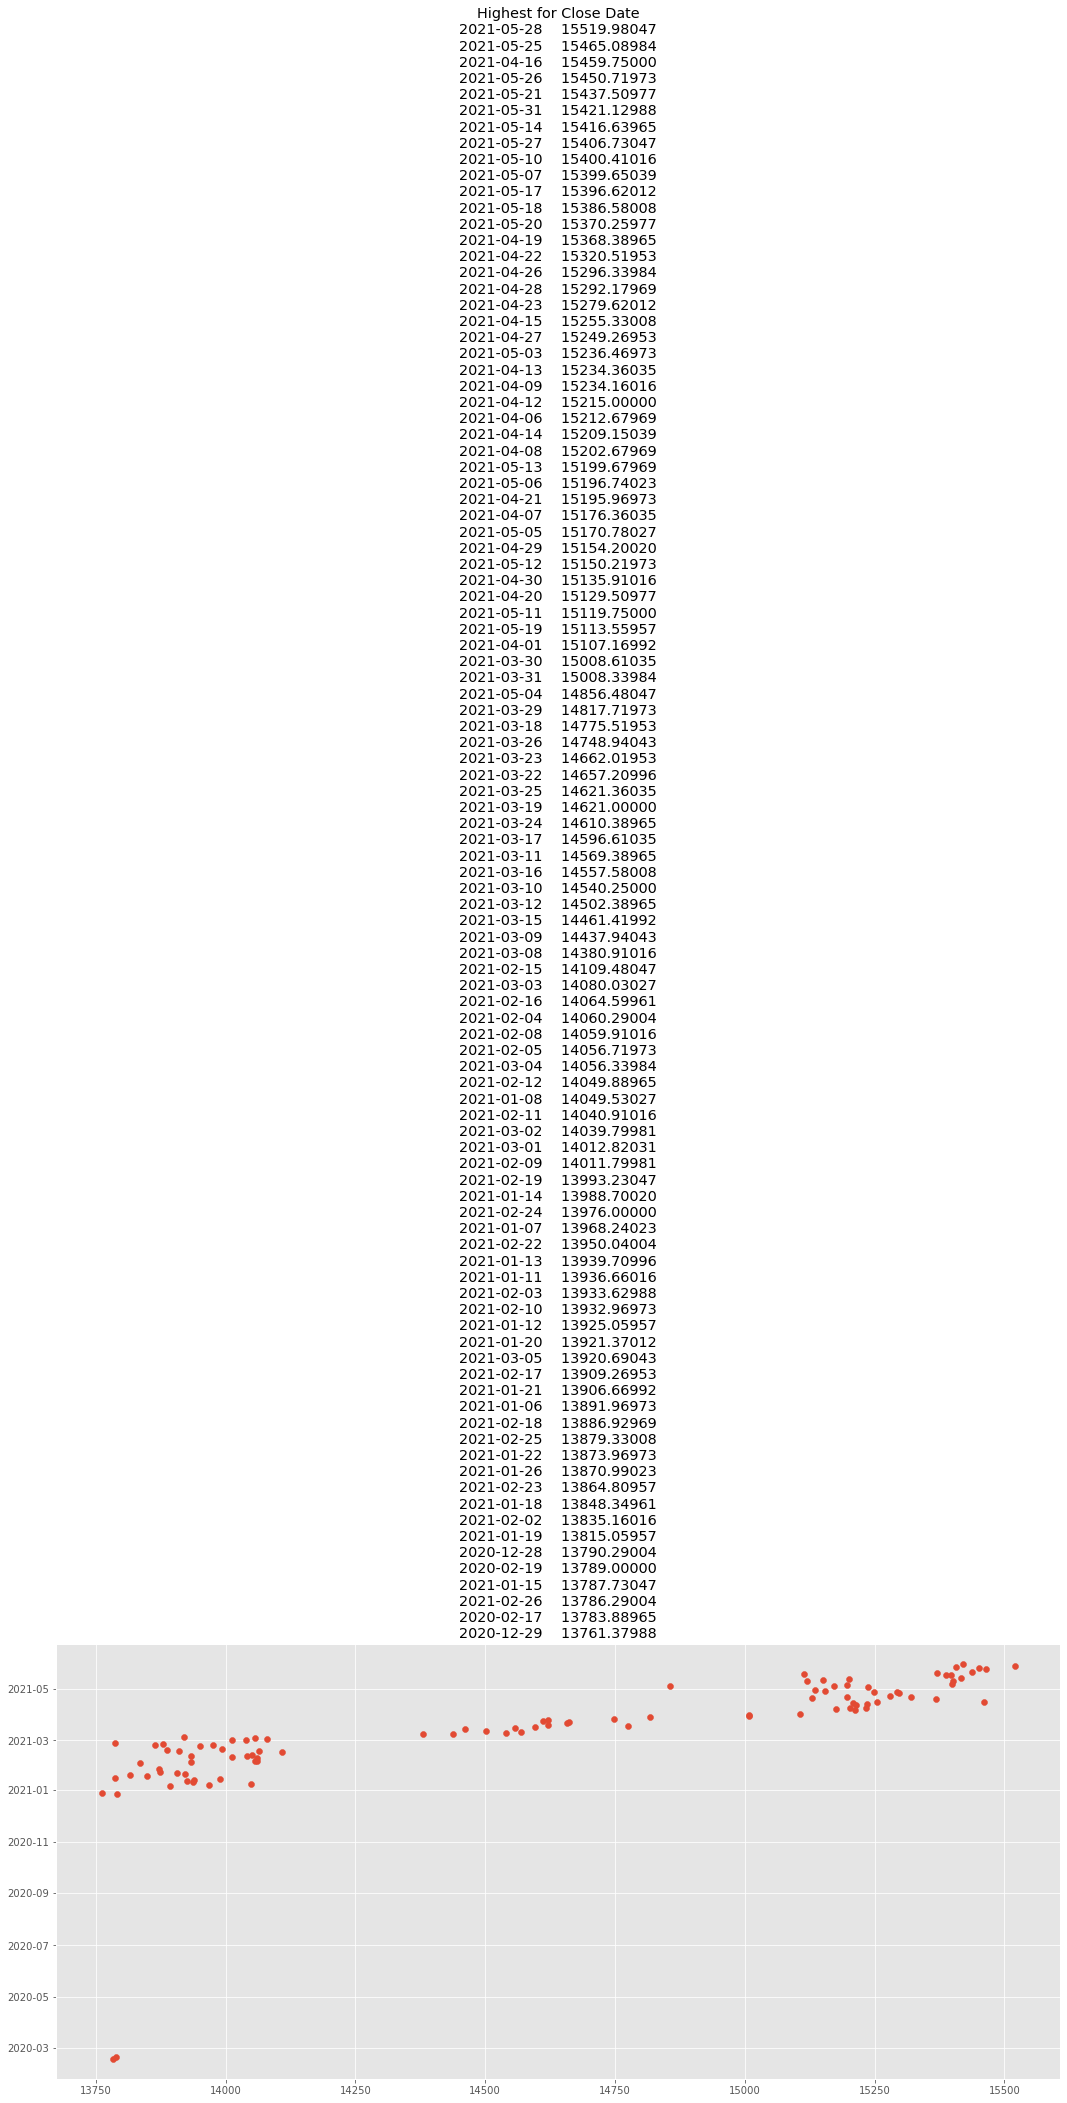

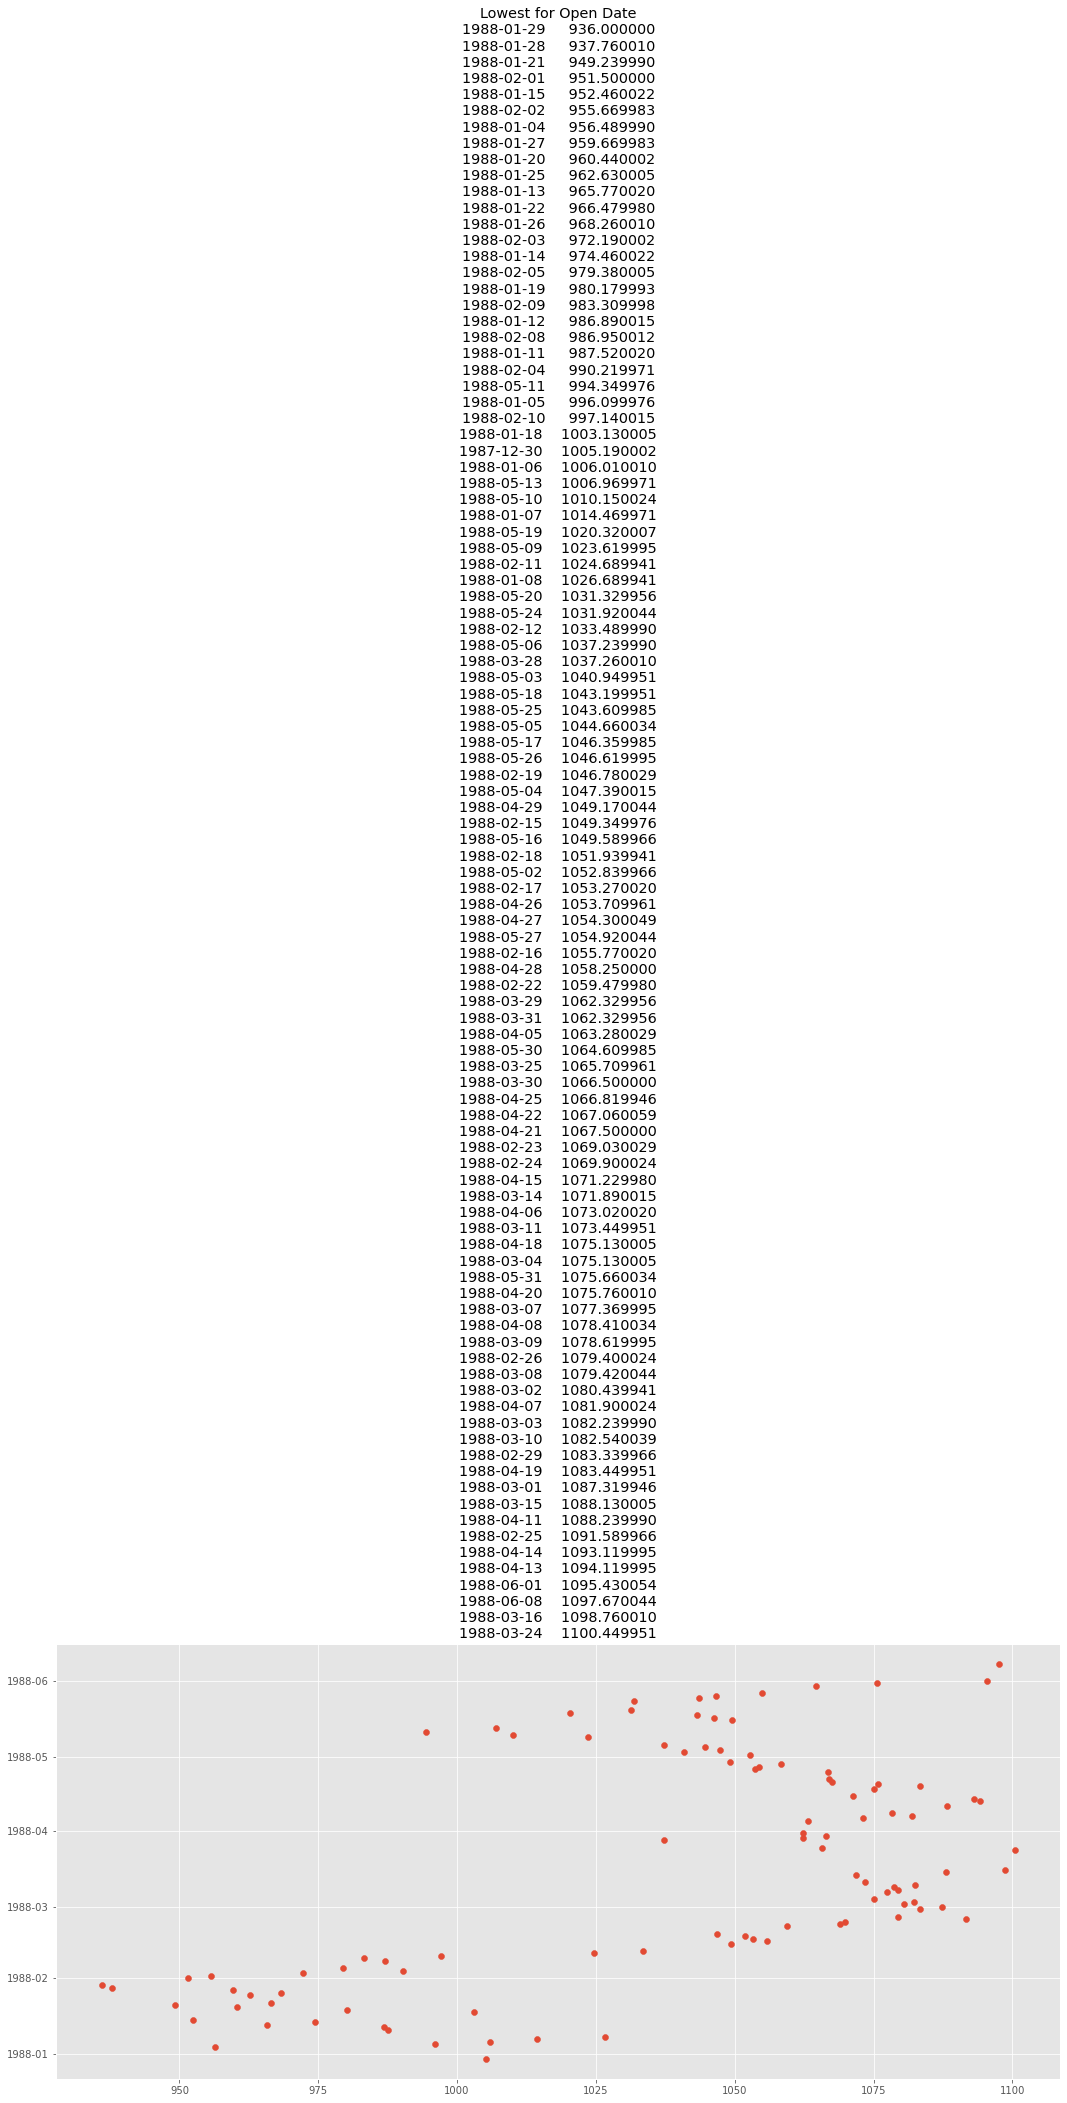

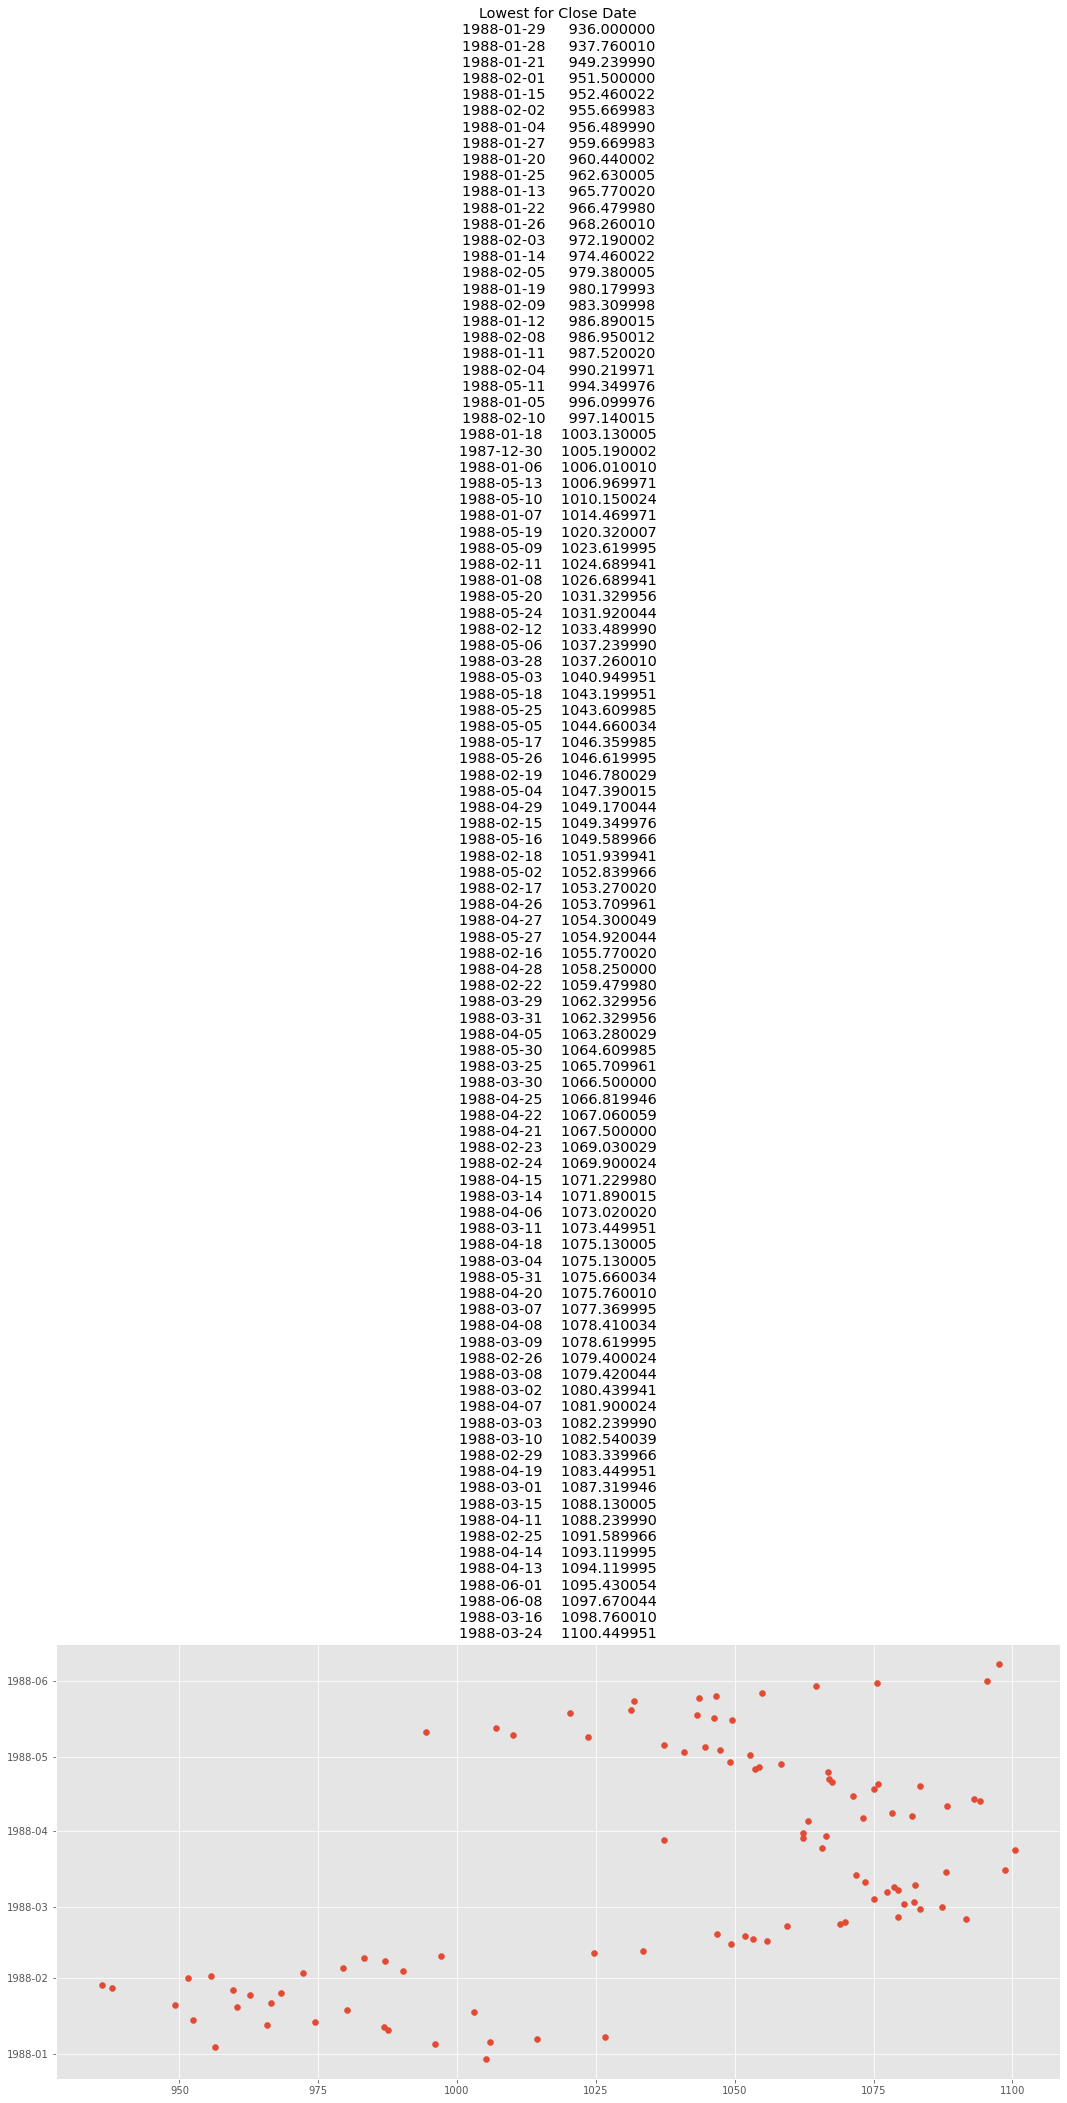

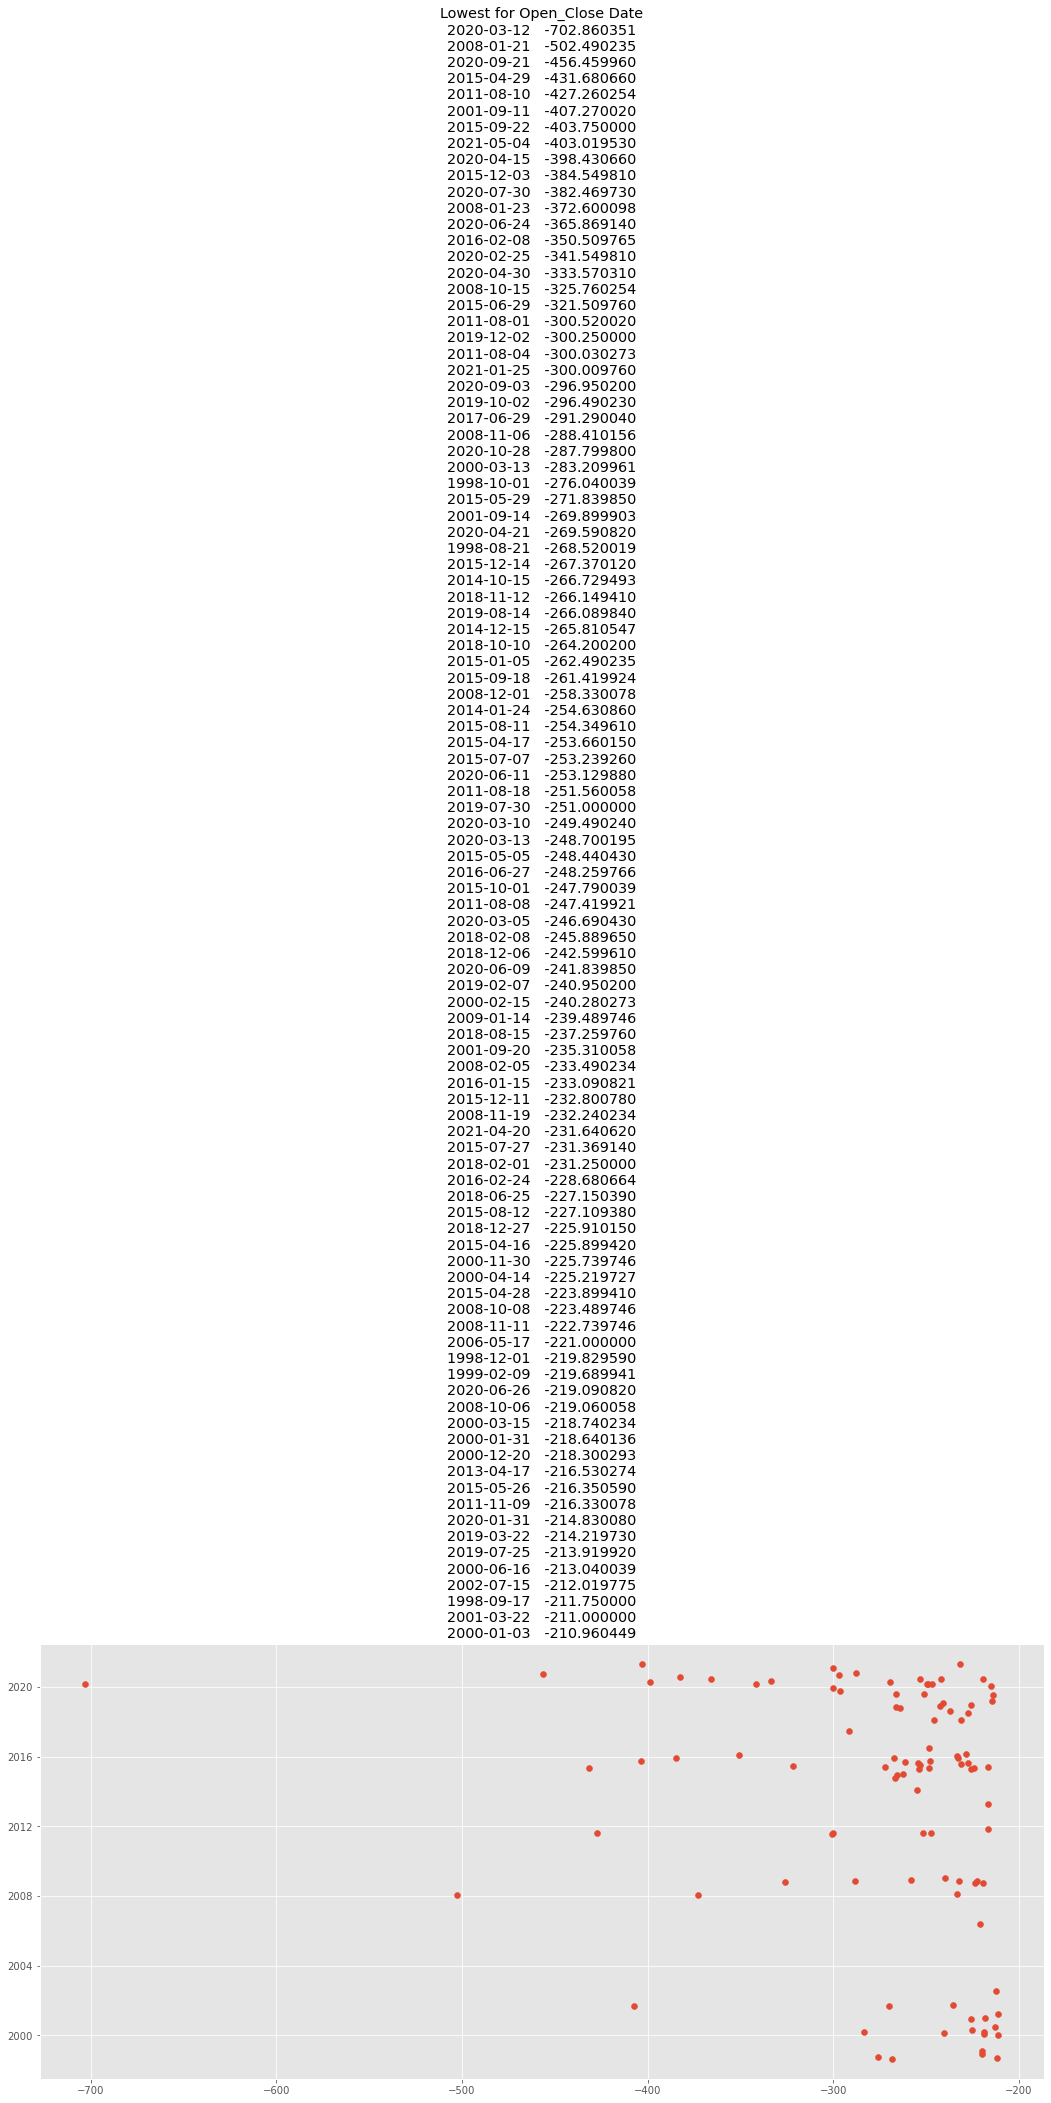

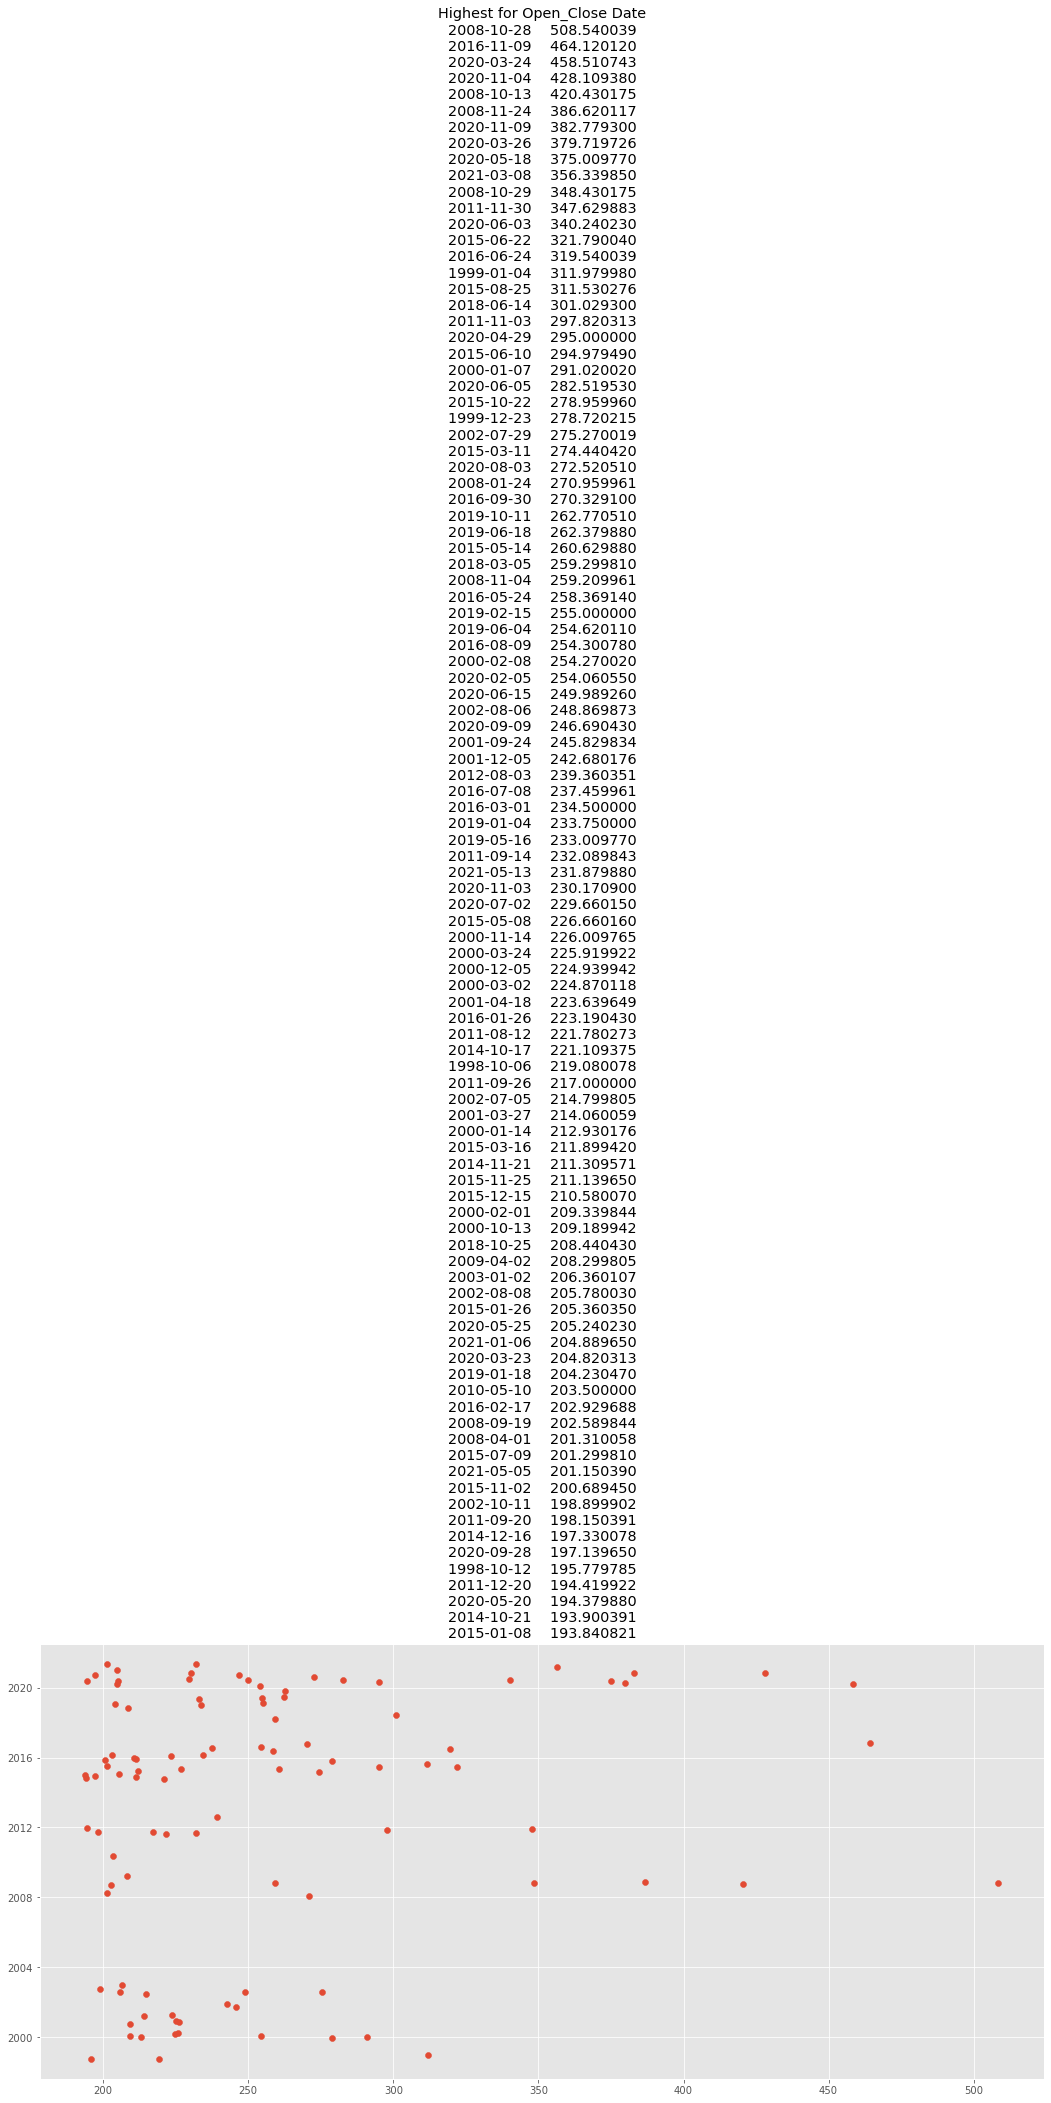

(8438, 9) (6567, 1) (1871, 1)


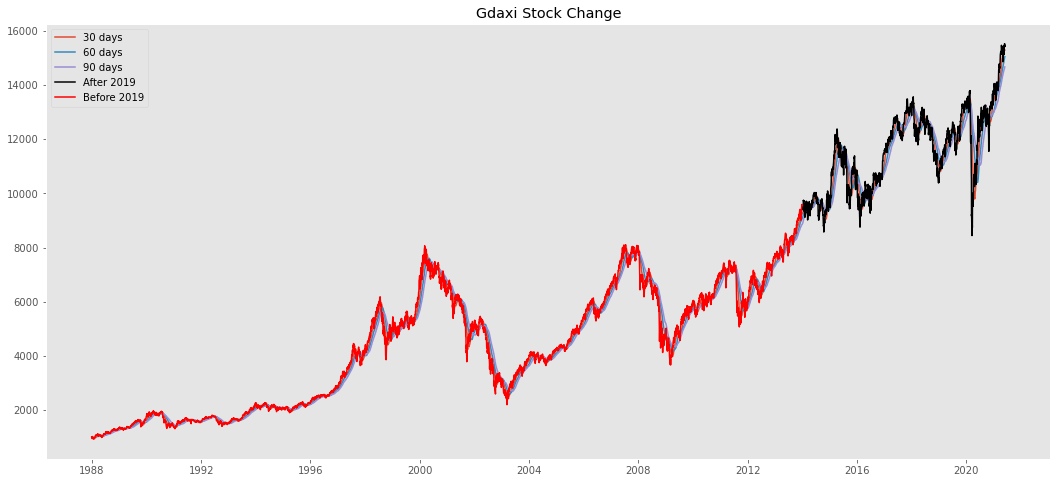

(6567, 1)
(1871, 1)
Epoch : 0 ( Mae Train Loss -> 0.24582362174987793 &  Validation Loss -> 0.919364333152771 )
Epoch : 1 ( Mae Train Loss -> 0.13797955214977264 &  Validation Loss -> 0.27185559272766113 )
Epoch : 2 ( Mae Train Loss -> 0.15707093477249146 &  Validation Loss -> 0.31333327293395996 )
Epoch : 3 ( Mae Train Loss -> 0.14058105647563934 &  Validation Loss -> 0.20299550890922546 )
Epoch : 4 ( Mae Train Loss -> 0.11199542135000229 &  Validation Loss -> 0.6539525389671326 )
Epoch : 5 ( Mae Train Loss -> 0.0828925296664238 &  Validation Loss -> 0.5172600150108337 )
Epoch : 6 ( Mae Train Loss -> 0.09215310215950012 &  Validation Loss -> 0.20975854992866516 )
Epoch : 7 ( Mae Train Loss -> 0.07174508273601532 &  Validation Loss -> 0.27880966663360596 )
Epoch : 8 ( Mae Train Loss -> 0.07321969419717789 &  Validation Loss -> 0.19218692183494568 )
Epoch : 9 ( Mae Train Loss -> 0.09188089519739151 &  Validation Loss -> 0.11464206874370575 )
Epoch : 10 ( Mae Train Loss -> 0.077662989497

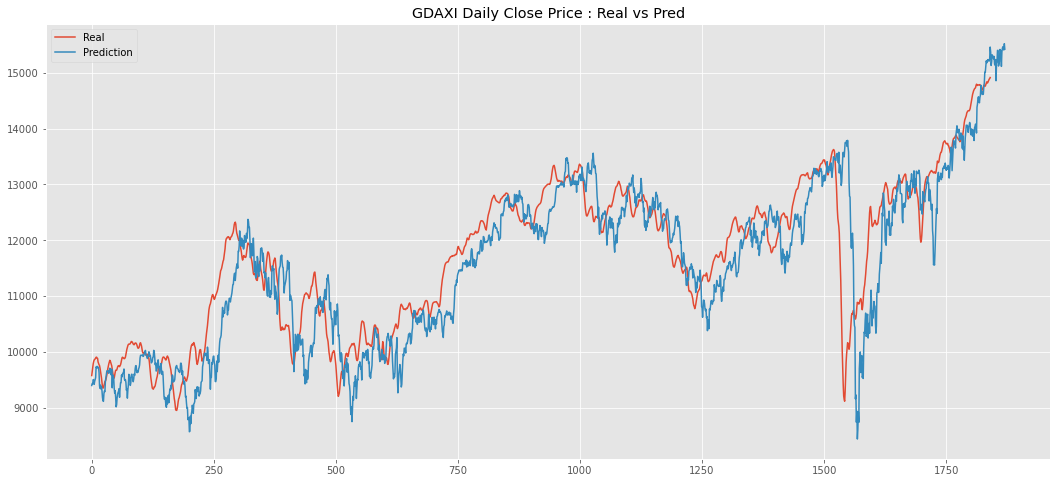

In [6]:

#%%

################################################################################
# Coded by  : Rose ( Pratama Azmi A)
# Date : 23/02/2023
# Text Editor : Vscode + Vim
# The dataset i used GDAXI ! 8438 in observed data in total 
# And i already give the SHAPE! below
# Sorry if the output is only in one cell, since i used .py when doing datascience 
################################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.models import Sequential
from typing import List,Tuple
plt.rcParams["figure.figsize"] = (18,8)
plt.style.use("ggplot")


#%%

class Callback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print("Epoch : %s ( Mae Train Loss -> %s &  Validation Loss -> %s )" %(epoch, logs["loss"],
                                                                                logs["val_loss"]))
        if(logs["val_loss"] < 0.10 and logs["loss"] < 0.10):
            self.model.stop_training= True
            print("Hit the validation MAE Loss <= 0.10")

    def on_predict_end(self, logs=None):
        print("Mae Loss for Validation Set is %s " %(logs["val_loss"]))
        
    


#%%
##### Utilities for visualizing
def printGeneralInformation(df : pd.DataFrame) -> None:
    print(df.info(),"\n\n") # Date is object dtype --> need to convert to datetime
    print(df.describe(),"\n\n")
    print("Null Value\n %s" %(df.isna().sum())) # 2204 Null

def plotIndexTrend(df : pd.DataFrame,indx_name : str ,listOfIndex : List[str]) -> None:

    for indx in listOfIndex:

        ## There's going 2 plot, the difference with previous day and also the close plot
        f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
        ax[0].plot(df[df[indx_name] == indx]["Open"])
        ax[0].set_title("%s Open Daily close price" %(indx))
        
        ax[1].plot(df[df[indx_name] == indx]["Close"])
        ax[1].set_title("%s Daily Close price" %(indx))

        ax[2].plot(df[df[indx_name] == indx]["Close"].diff()) # Diff each day!
        ax[2].set_title("%s Daily Close price difference each day" %(indx))

        plt.show()

def printHighest(df : pd.DataFrame, columnName : str, n : int = 5) -> None :
    srt : pd.Series = df.sort_values(columnName, ascending= False)[columnName][:n]
    plt.scatter(srt.values, srt.index)
    plt.title("Highest for %s " %(columnName) + srt.to_string())
    plt.show()

def printLowest(df : pd.DataFrame, columnName : str, n : int = 5) -> None:
    srt : pd.Series = df.sort_values(columnName, ascending= True)[columnName][:n]
    plt.scatter(srt.values, srt.index)
    plt.title("Lowest for %s " %(columnName) + srt.to_string())
    plt.show()

def plot2LinePlots(df : pd.DataFrame, colName1 : str,
                   colName2 : str, titleP1 : str, titleP2 : str ) -> None:
    f, ax = plt.subplots(nrows=1, ncols=2,  figsize=(18, 8))
    ax[0].plot(df[colName1])
    ax[0].set_title(titleP1)

    ax[1].plot(df[colName2])
    ax[1].set_title(titleP2)


def printOpenCloseDifference(df : pd.DataFrame, 
                                    colName : str,
                                    n : int=5,
                                    asc : bool = False) -> None:
    printLowest(df,colName,n)
    printHighest(df,colName,n)

def plotRolling(df : pd.DataFrame, colName : str ,listOfRolling : List[int],
                 listOfLabels : List[str], title : str):
    for indx in range(0, len(listOfLabels)):
        plt.plot(df[colName].rolling(listOfRolling[indx]).mean(), label=listOfLabels[indx])
        plt.title(title)
        plt.legend()


def prepareTestingData(df : pd.DataFrame, colName : str , date_str : str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    test_size : int = len(df[df.index > date_str]) 
    train_dataset : pd.DataFrame = df[[colName]][:-test_size]
    test_dataset : pd.DataFrame = df[[colName]][-test_size:]

    return train_dataset, test_dataset

def prepareScaler_fit(train_dataset : pd.DataFrame, test_dataset: pd.DataFrame) -> Tuple[StandardScaler, np.array , np.array ] :
    train_standardScaler : StandardScaler = StandardScaler()

    train_dataset_scaled  : np.array = train_standardScaler.fit_transform(train_dataset)
    test_dataset_scaled : np.array = train_standardScaler.transform(test_dataset)

    return train_standardScaler, train_dataset_scaled, test_dataset_scaled


def defineModel(name : str) -> tf.keras.Sequential :

    model : tf.keras.Sequential = tf.keras.Sequential(name=name)
    model.add(LSTM(128, return_sequences= True, input_shape=(n_length, 1))) # (30, 1) Sesuai Batches 
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dense(128, activation=tf.nn.tanh))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation=tf.nn.relu))
    model.add(Dense(1))


    model.compile(
        optimizer = tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.MeanAbsoluteError()
    )

    return model


def printPlotComparison(scaler : StandardScaler, yTrue : pd.DataFrame,
                         yPred:pd.DataFrame, title : str) -> None:
    scaled_dat_yTrue : np.array = scaler.inverse_transform(yTrue)
    scaled_dat_yPred : np.array = scaler.inverse_transform(yPred)

    plt.plot(scaled_dat_yTrue , label="Real")
    plt.plot(scaled_dat_yPred, label="Prediction")
    plt.title(title)
    plt.legend()


#%%
df : pd.DataFrame = pd.read_csv("indexProcessed.csv")
printGeneralInformation(df)
#%%
print(df["Index"].unique()) # 
#%%
df["Date"] = pd.to_datetime(df["Date"])
# Making the date as the index 
df_date : pd.DataFrame = df.sort_values(["Index", "Date"]).set_index("Date")
print(df_date.head(2))
# %%
plotIndexTrend(df_date,"Index", df_date["Index"].unique())
#%%

# Exploratory Data Analysis for GDAXI
gdaxi_df : pd.DataFrame = df_date[df_date["Index"] == "GDAXI"]
gdaxi_df["Open_Close"] = gdaxi_df["Close"].values - gdaxi_df["Open"].values
print(gdaxi_df.isna().sum())
plot2LinePlots(gdaxi_df, "Open", "Open_Close", "Gdaxi Open Daily Price", "Gdaxi Open-Close daily Price")
# %%
n : int = 100
printHighest(gdaxi_df, "Open",n)
printHighest(gdaxi_df, "Close",n)

printLowest(gdaxi_df, "Open",n)
printLowest(gdaxi_df, "Close",n)

printOpenCloseDifference(gdaxi_df, "Open_Close",n)

# %%
rollingInfo : List[int] = [30,60,90]
labelsInfo : List[str] = ["30 days", "60 days", "90 days"]
plotRolling(gdaxi_df,"Close", rollingInfo, labelsInfo, "GDXAII CLOSE ")
#%%

########################################################################################
#####
##### VALIDATION SET is 22 % ! 
##### TOTAL GDAXI = 8438
##### TRAIN GDAXI = 6567
##### PROOF = 8438 * 20 = 1687 OBSERVER DATA! ( 1687 * 100 / 8438) = 20 percent !
##### VALIDATION GDAXI = 1871 (1871 * 100 / 8438) = 22 Percent !
########################################################################################
gdaxi_train, gdaxi_test = prepareTestingData(gdaxi_df, "Close", "2014-01-01")
print(gdaxi_df.shape,
      gdaxi_train.shape,
      gdaxi_test.shape)
plt.plot(gdaxi_test, label="After 2019", color="black")
plt.plot(gdaxi_train, label="Before 2019", color="red")
plt.legend()
plt.grid()
plt.title("Gdaxi Stock Change")
plt.show()
#%%
##3 Datapreparation
gdaxi_scaler, gdaxi_train_scaled, gdaxi_test_scaled = prepareScaler_fit(gdaxi_train, gdaxi_test)

print(gdaxi_train_scaled.shape)
print(gdaxi_test_scaled.shape)

## TimeStep = 30 day
n_length : int = 30
## Each batch has 30 day !
train_gdaxi_generator : TimeseriesGenerator = TimeseriesGenerator(gdaxi_train_scaled,gdaxi_train_scaled, length=n_length)
test_gdaxi_generator : TimeseriesGenerator = TimeseriesGenerator(gdaxi_test_scaled, gdaxi_test_scaled,length=n_length )

# Modelling
model_gdaxi : tf.keras.Model = defineModel("GDAXI")
EPOCHS : int = 100
model_gdaxi_history : dict = model_gdaxi.fit(
    train_gdaxi_generator,
    validation_data=(test_gdaxi_generator),
    batch_size=1, epochs=EPOCHS, verbose =0,callbacks=[Callback()])
 # BATCH_SIZE 1, because we already batched it on TIMERSERIESGENERATOR
#%%
prediction = model_gdaxi.predict(test_gdaxi_generator)
printPlotComparison(gdaxi_scaler, prediction, gdaxi_test_scaled, "GDAXI Daily Close Price : Real vs Pred")


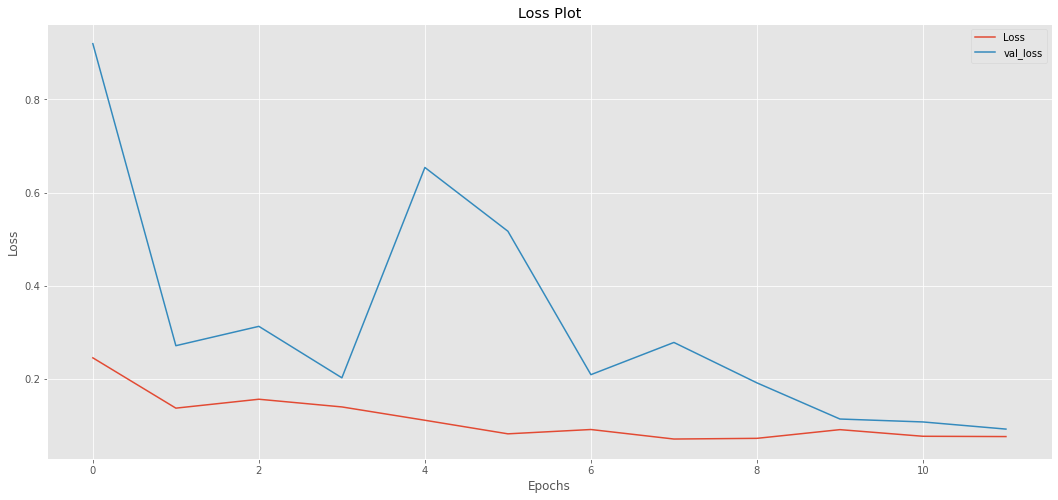

In [7]:
def plotHistoryLoss(history : dict) -> None:
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss Plot")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss","val_loss"])
    plt.show()


plotHistoryLoss(model_gdaxi_history)

plotHistoryLoss(model_gdaxi_history)